## Final Project Submission

Please fill out:
* Student name: Sabatino Chen
* Student pace: full time
* Scheduled project review date/time: 5/17/2019 2PM EST
* Instructor name: Joe San Pietro
* Blog post URL: https://medium.com/@sabatinochen/deep-learning-b04a42c5a341


# Intro

[LendingClub](https://www.lendingclub.com/) is a peer-to-peer lending company as explained by [Wikipedia](https://en.wikipedia.org/wiki/LendingClub): 

"LendingClub enables borrowers to create unsecured personal loans between \\$1,000 and $40,000. The standard loan period is three years. Investors can search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. LendingClub makes money by charging borrowers an origination fee and investors a service fee."

For this project I will be making a Deep Neural Network that will classify whether a loan will be "Charged Off" or "Fully paid". This can be useful for investors determining which loans or loan portfolios they would like to invest in on the LendingClub platform. I will be using a dataset from LendingClub that has records of loans accepted from 2007 to the third quarter of 2017.

Charged Off: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
 

# Obtain Data

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Data/accepted_2007_to_2017Q3.csv', low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


Notice how there are 1,646,801 loans with 150 features.

# Scrub Data

The target value we will be classifying is `loan_status`, let's take a look at this column.

In [4]:
df.loan_status.value_counts(normalize=True)

Current                                                0.479087
Fully Paid                                             0.392829
Charged Off                                            0.102068
Late (31-120 days)                                     0.014430
In Grace Period                                        0.006360
Late (16-30 days)                                      0.003514
Does not meet the credit policy. Status:Fully Paid     0.001207
Does not meet the credit policy. Status:Charged Off    0.000462
Default                                                0.000043
Name: loan_status, dtype: float64

Since we are predicting whether the loan was fully paid or charged off, we will not be using current loans to build the DNN, but we will save them as a separate dataframe for later down to make predictions.  Also the other labels listed above that make up 1% or less of the dataset won't be used since they are rare occurences.

In [5]:
# Drop rows not in 'Fully Paid' or 'Charged Off'
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Current',
                                    'Does not meet the credit policy. Status:Fully Paid', 
                                    'Does not meet the credit policy. Status:Charged Off'])]
df.shape

(1606685, 150)

In [6]:
# Combine other labels into fully paid or charged off
df.loan_status.replace(to_replace='Does not meet the credit policy. Status:Fully Paid', 
                       value= 'Fully Paid', inplace=True)
df.loan_status.replace(to_replace='Does not meet the credit policy. Status:Charged Off', 
                       value= 'Charged Off', inplace=True)

In [7]:
df.loan_status.value_counts(normalize=True)

Current        0.491042
Fully Paid     0.403869
Charged Off    0.105089
Name: loan_status, dtype: float64

Notice how we are dealing with a bit of an unbalanced dataset between Charged Off and Fully Paid, we will probably have to do something about this later in order to get good results.

Now lets start checking for null values

In [8]:
# Finding the the count and percentage of values that are missing in the dataframe.
df_null = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})

# printing columns with null count more than 0
df_null[df_null['Count'] > 0] 

,Count,Percent
member_id,1606685,100.000000
emp_title,99778,6.210178
emp_length,92575,5.761864
annual_inc,4,0.000249
desc,1480889,92.170463
title,22195,1.381416
zip_code,1,0.000062
dti,348,0.021660
delinq_2yrs,29,0.001805
earliest_cr_line,29,0.001805


Here we can see that there are many columns with null values, and many with over 80%! Since it will be hard to make any use of these columns we will remove any missing at least 30%. This will also help reduce how many features we are dealing with.

In [9]:
# Remove columns missing 30% of data
df = df.dropna(axis=1, thresh=int(0.70*len(df)))

In [10]:
df.shape

(1606685, 92)

Now to the best of my ability, I will go through LendingClub's explanations of all the features and remove any that seem unncessary or not readily available for investors since this model will be used to try and predict which types of loans to invest in on the LendingClub platform or based on the availble information. Below are images of what it looks like to use the LendingClub platform in order to decide on loans you want to invest in.  

With the lack of resources of being able to discuss important features with someone with more domain expertise than myself my methodology was to use this information below along with the descriptions from the Data Dictionary to determine which features to keep going forward.

<img src='Screen Shot 2019-05-10 at 11.00.51 AM.png'>

<img src='Screen Shot 2019-05-10 at 11.02.40 AM.png' height=40%>


<img src='Screen Shot 2019-05-11 at 8.01.51 PM.png' height=40%>

In [11]:
# Here is our list of remaining features so far
print(sorted(df.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

In [12]:
# Reading in feature explanations from LC's Data Dictionary
df_description = pd.read_excel('LCDataDictionary.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [13]:
# Features being kept after going through LC Data Dictionary
keep_list = ['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type', 'collections_12_mths_ex_med', 
             'delinq_2yrs', 'delinq_amnt', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 
             'fico_range_low', 'funded_amnt', 'grade', 'home_ownership','inq_last_6mths', 'installment', 'int_rate', 
             'issue_d', 'loan_amnt', 'loan_status', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 
             'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status']

In [14]:
# Remaining features to be dropped after intial feature analysis
drop_list = [col for col in df.columns if col not in keep_list]
print(drop_list)

['id', 'funded_amnt_inv', 'pymnt_plan', 'zip_code', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'policy_code', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'to

In [15]:
df = df.drop(labels=drop_list, axis=1)
df.shape

(1606685, 33)

## Colinearity

In [26]:
def multi_collinearity_heatmap(df, figsize=(11,9), annot=False):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, annot=annot, 
                cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

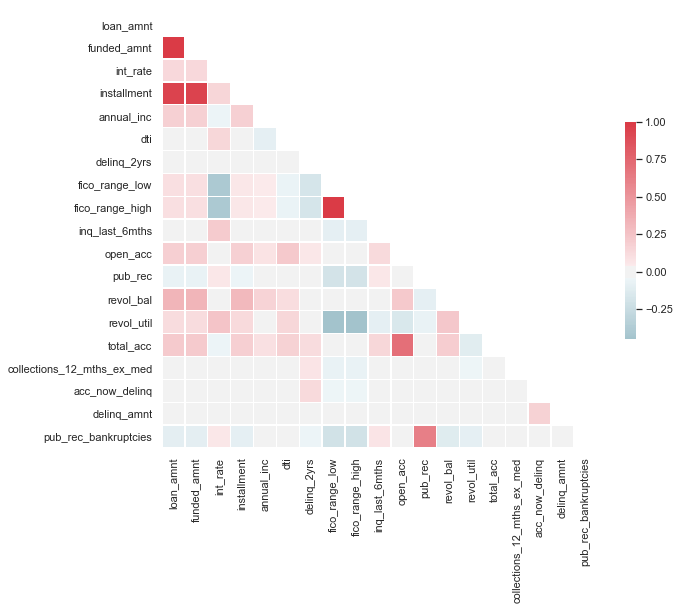

In [27]:
# Checking for multi-collinearity
multi_collinearity_heatmap(df, figsize=(10,8))

After checking for collinearity, we can drop `loan_amnt`, `installment`, `open_acc`, and `pub_rec`

In [28]:
# drop columns with collinearity
# FICO can drop later after taking average
df = df.drop(['loan_amnt', 'installment', 'open_acc', 'pub_rec'], axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606685 entries, 0 to 1646798
Data columns (total 29 columns):
funded_amnt                   1606685 non-null float64
term                          1606685 non-null object
int_rate                      1606685 non-null float64
grade                         1606685 non-null object
sub_grade                     1606685 non-null object
emp_title                     1506907 non-null object
emp_length                    1514110 non-null object
home_ownership                1606685 non-null object
annual_inc                    1606681 non-null float64
verification_status           1606685 non-null object
issue_d                       1606685 non-null object
loan_status                   1606685 non-null object
purpose                       1606685 non-null object
title                         1584490 non-null object
addr_state                    1606685 non-null object
dti                           1606337 non-null float64
delinq_2yrs        

### Checkpoint 1

In [30]:
# Create new csv so don't have to load large dataset every time
# df.to_csv('loans_smaller_with_current.csv', index=False)

In [2]:
df = pd.read_csv('Data/loans_smaller_with_current.csv', low_memory=False)
df.head()

,funded_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,fico_range_high,inq_last_6mths,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies
0,15000.0,60 months,12.39,C,C1,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,...,754.0,0.0,138008.0,29.0,17.0,0.0,Individual,0.0,0.0,0.0
1,10400.0,36 months,6.99,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,...,714.0,2.0,6133.0,31.6,36.0,0.0,Individual,0.0,0.0,0.0
2,21425.0,60 months,15.59,D,D1,Programming Analysis Supervisor,6 years,RENT,63800.0,Source Verified,...,689.0,0.0,16374.0,76.2,35.0,0.0,Individual,0.0,0.0,0.0
3,12800.0,60 months,17.14,D,D4,Senior Sales Professional,10+ years,MORTGAGE,125000.0,Verified,...,669.0,0.0,5753.0,100.9,13.0,0.0,Individual,0.0,0.0,0.0
4,7650.0,36 months,13.66,C,C3,Technical Specialist,< 1 year,RENT,50000.0,Source Verified,...,689.0,1.0,16822.0,91.9,20.0,0.0,Individual,0.0,0.0,0.0


## Categorical Cleaning
For further cleaning I will examine the categorcial data

In [3]:
df.columns.groupby(df.dtypes)

{dtype('float64'): Index(['funded_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
        'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'revol_bal',
        'revol_util', 'total_acc', 'collections_12_mths_ex_med',
        'acc_now_delinq', 'delinq_amnt', 'pub_rec_bankruptcies'],
       dtype='object'),
 dtype('O'): Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'verification_status', 'issue_d', 'loan_status',
        'purpose', 'title', 'addr_state', 'earliest_cr_line',
        'application_type'],
       dtype='object')}

In [4]:
categorical_df = df[['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'verification_status', 'issue_d', 'loan_status',
        'purpose', 'title', 'addr_state', 'earliest_cr_line',
        'application_type']]
categorical_df.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,addr_state,earliest_cr_line,application_type
0,60 months,C,C1,MANAGEMENT,10+ years,RENT,Source Verified,Dec-2014,Fully Paid,debt_consolidation,Debt consolidation,VA,Aug-1994,Individual
1,36 months,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,Not Verified,Dec-2014,Charged Off,credit_card,Credit card refinancing,CA,Sep-1989,Individual
2,60 months,D,D1,Programming Analysis Supervisor,6 years,RENT,Source Verified,Dec-2014,Fully Paid,credit_card,Credit card refinancing,MO,Aug-2003,Individual
3,60 months,D,D4,Senior Sales Professional,10+ years,MORTGAGE,Verified,Dec-2014,Current,car,Car financing,CA,Oct-2000,Individual
4,36 months,C,C3,Technical Specialist,< 1 year,RENT,Source Verified,Dec-2014,Charged Off,debt_consolidation,Debt consolidation,AZ,Aug-2002,Individual


In [5]:
categorical_df.isna().sum()/len(categorical_df)

term                   0.000000
grade                  0.000000
sub_grade              0.000000
emp_title              0.062102
emp_length             0.057619
home_ownership         0.000000
verification_status    0.000000
issue_d                0.000000
loan_status            0.000000
purpose                0.000000
title                  0.013814
addr_state             0.000000
earliest_cr_line       0.000018
application_type       0.000000
dtype: float64

### term

In [6]:
df.term.value_counts()

 36 months    1157429
 60 months     449256
Name: term, dtype: int64

In [7]:
# Will make term values into integers
df.term = df.term.apply(lambda x: int(x[:3]))
df.term.value_counts()

36    1157429
60     449256
Name: term, dtype: int64

### grade and sub_grade

In [8]:
# grade and sub_grade seem to be related
print('grade:', df.grade.unique())
print('sub grade:', df.sub_grade.unique())

grade: ['C' 'A' 'D' 'B' 'E' 'F' 'G']
sub grade: ['C1' 'A3' 'D1' 'D4' 'C3' 'B5' 'B4' 'C4' 'D5' 'E5' 'B3' 'C5' 'D2' 'E3'
 'C2' 'B2' 'E4' 'A4' 'D3' 'B1' 'A5' 'F1' 'E1' 'E2' 'G2' 'G1' 'F3' 'F2'
 'A1' 'A2' 'G3' 'F4' 'G4' 'F5' 'G5']


In [9]:
# Will drop grade since it is shown in sub_grade
df = df.drop('grade', axis=1)

### emp_title

In [10]:
# emp_title seems to have some nulls and a lot of values in general
# This would cause high dimensionality after getting dummy variables
df.emp_title.nunique()

427077

In [11]:
# With that many different types of titles, will just drop the column
df = df.drop('emp_title', axis=1)

### emp_length

In [12]:
df.emp_length.value_counts(dropna=False)

10+ years    536410
2 years      144686
< 1 year     129967
3 years      127607
1 year       104964
5 years       99349
4 years       95709
NaN           92575
6 years       73882
8 years       70899
7 years       68856
9 years       61781
Name: emp_length, dtype: int64

In [13]:
# Will convert these to numerical data and make the NaN values equal to 0 and < 1 equal to 0.5
df.emp_length.replace(to_replace='10+ years', value='10 years', inplace=True)
df.emp_length.replace(to_replace='< 1 year', value='15 years', inplace=True)
df.emp_length.fillna('0 years', inplace=True)

In [14]:
# marked < 1 year as 15 years so can change to 0.5
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
df.emp_length.replace(to_replace=15.0, value=0.5, inplace=True)
df.emp_length.value_counts(dropna=False)

10.0    536410
2.0     144686
0.5     129967
3.0     127607
1.0     104964
5.0      99349
4.0      95709
0.0      92575
6.0      73882
8.0      70899
7.0      68856
9.0      61781
Name: emp_length, dtype: int64

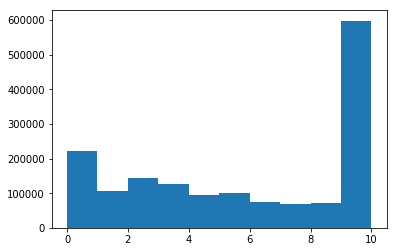

In [15]:
plt.hist(df['emp_length'])
plt.show()

### home_ownership

In [16]:
df.home_ownership.value_counts(dropna=False)

MORTGAGE    797546
RENT        635355
OWN         173056
ANY            492
OTHER          182
NONE            54
Name: home_ownership, dtype: int64

In [17]:
# Since above in the Data Dictionary they only use MORTGAGE, RENT, OWN, and OTHER, will combine ANY and NONE with OTHER
df.home_ownership.replace(['ANY', 'NONE'], 'OTHER', inplace=True)
df.home_ownership.value_counts(dropna=False)

MORTGAGE    797546
RENT        635355
OWN         173056
OTHER          728
Name: home_ownership, dtype: int64

### issue_d

In [18]:
df.issue_d.value_counts()

Mar-2016    59887
Oct-2015    47169
Jul-2015    44760
Dec-2015    42841
Aug-2017    42724
Sep-2017    39052
Jul-2017    38405
Oct-2014    38384
Feb-2016    38157
Jun-2017    36947
May-2017    36487
Nov-2015    36333
Mar-2017    35940
Apr-2016    35088
Aug-2015    34903
Aug-2016    34747
Dec-2016    34634
Apr-2015    34520
Jan-2015    34331
Jul-2016    33254
Nov-2016    33171
Jun-2016    31688
Oct-2016    31559
Jan-2016    31317
May-2015    31065
Jan-2017    30671
Jul-2014    29076
Apr-2017    28631
Sep-2015    27778
Jun-2015    27619
            ...  
Dec-2009      658
Oct-2009      604
Sep-2009      507
Aug-2009      446
Jul-2009      411
Jun-2009      406
Mar-2008      402
May-2009      359
Apr-2009      333
Mar-2009      324
Feb-2008      306
Jan-2008      305
Feb-2009      302
Jan-2009      269
Apr-2008      259
Dec-2008      253
Nov-2008      209
Dec-2007      172
Jul-2008      141
Jun-2008      124
Oct-2008      122
May-2008      115
Nov-2007      112
Oct-2007      105
Aug-2008  

In [19]:
df.issue_d = df.issue_d.apply(lambda x: int(x[-4:]))
df.issue_d.head()

0    2014
1    2014
2    2014
3    2014
4    2014
Name: issue_d, dtype: int64

### title

In [20]:
df.title.nunique()

63079

In [21]:
# With this many different titles we will drop this feature, also has some null values
df = df.drop('title', axis=1)

### earliest_cr_line

In [22]:
df.earliest_cr_line.value_counts()

Aug-2001    11101
Sep-2003    10927
Aug-2002    10889
Sep-2004    10594
Aug-2000    10588
Sep-2002    10500
Aug-2003    10468
Oct-2001    10310
Oct-2003    10129
Oct-2002    10100
Oct-2000    10060
Aug-2004     9978
Sep-2005     9545
Nov-1999     9542
Sep-2000     9526
Nov-2000     9467
Jul-2003     9387
Sep-2001     9348
Oct-2004     9291
Oct-1999     9206
Aug-2005     9064
Aug-1999     9042
Nov-2001     8980
Sep-1999     8938
Jul-2001     8759
Jul-2002     8693
Aug-2006     8662
Mar-2001     8541
Dec-2001     8533
Jul-2004     8472
            ...  
Oct-1954        1
Jul-1955        1
Nov-1950        1
May-1957        1
Dec-1951        1
Aug-1946        1
Mar-1933        1
Aug-1941        1
Oct-1950        1
Sep-1951        1
Nov-1952        1
May-1950        1
Aug-1957        1
Nov-1955        1
Jul-1952        1
Sep-1957        1
Oct-1957        1
Mar-1958        1
Dec-1950        1
Sep-1953        1
Mar-1957        1
Mar-1954        1
May-1953        1
Feb-1934        1
Jan-1946  

In [23]:
# With this wide range of dates, will just take the years and convert into integers
# Will also drop very small amount of data with null values.
df.earliest_cr_line.dropna(inplace=True)
df.earliest_cr_line = df.earliest_cr_line.apply(lambda x: int(x[-4:]))
df.earliest_cr_line.head()

0    1994.0
1    1989.0
2    2003.0
3    2000.0
4    2002.0
Name: earliest_cr_line, dtype: float64

In [24]:
df.columns.groupby(df.dtypes)

{dtype('int64'): Index(['term', 'issue_d'], dtype='object'),
 dtype('float64'): Index(['funded_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti',
        'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high',
        'inq_last_6mths', 'revol_bal', 'revol_util', 'total_acc',
        'collections_12_mths_ex_med', 'acc_now_delinq', 'delinq_amnt',
        'pub_rec_bankruptcies'],
       dtype='object'),
 dtype('O'): Index(['sub_grade', 'home_ownership', 'verification_status', 'loan_status',
        'purpose', 'addr_state', 'application_type'],
       dtype='object')}

In [25]:
categorical_df = df[['sub_grade', 'home_ownership', 'verification_status', 'loan_status',
        'purpose', 'addr_state', 'application_type']]

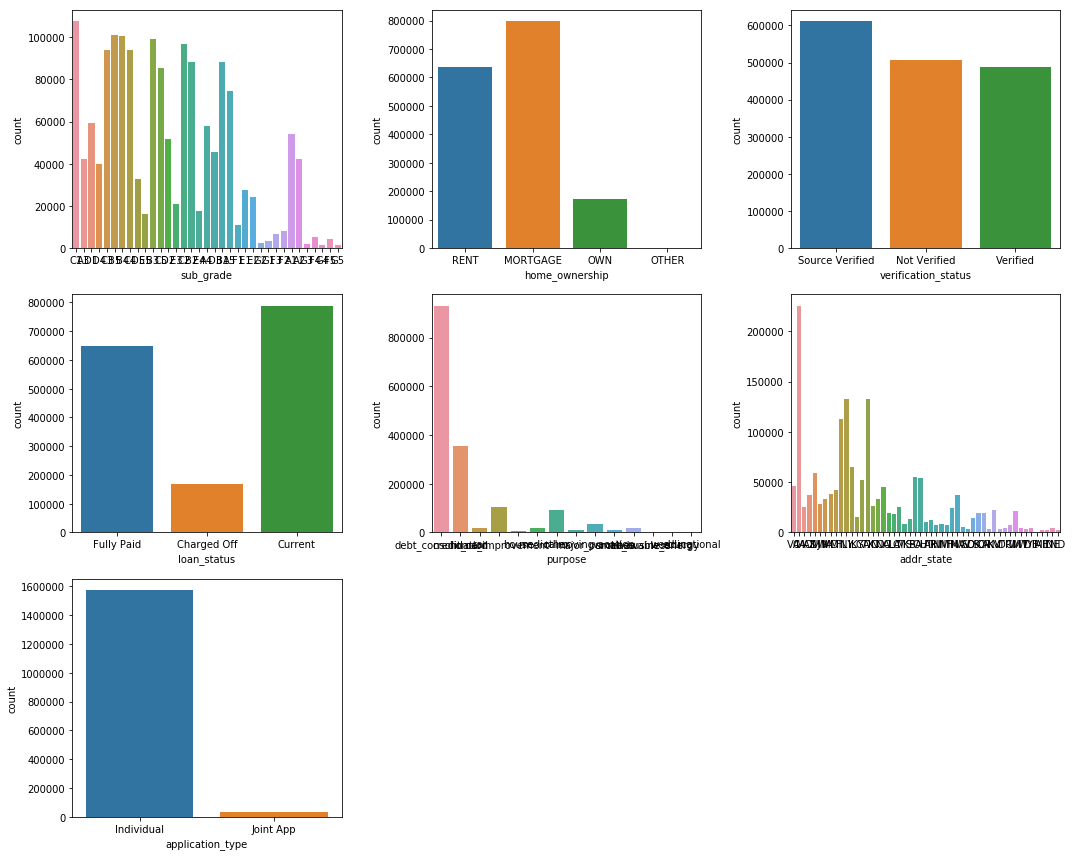

In [26]:
fig = plt.figure(figsize=(15,12))
ax1 = plt.subplot(331)
sns.countplot(categorical_df['sub_grade'])
ax2 = plt.subplot(332)
sns.countplot(categorical_df['home_ownership'])
ax3 = plt.subplot(333)
sns.countplot(categorical_df['verification_status'])
ax4 = plt.subplot(334)
sns.countplot(categorical_df['loan_status'])
ax5 = plt.subplot(335)
sns.countplot(categorical_df['purpose'])
ax6 = plt.subplot(336)
sns.countplot(categorical_df['addr_state'])
ax7 = plt.subplot(337)
sns.countplot(categorical_df['application_type'])
plt.tight_layout()
plt.show()

## Numerical Cleaning

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606685 entries, 0 to 1606684
Data columns (total 26 columns):
funded_amnt                   1606685 non-null float64
term                          1606685 non-null int64
int_rate                      1606685 non-null float64
sub_grade                     1606685 non-null object
emp_length                    1606685 non-null float64
home_ownership                1606685 non-null object
annual_inc                    1606681 non-null float64
verification_status           1606685 non-null object
issue_d                       1606685 non-null int64
loan_status                   1606685 non-null object
purpose                       1606685 non-null object
addr_state                    1606685 non-null object
dti                           1606337 non-null float64
delinq_2yrs                   1606656 non-null float64
earliest_cr_line              1606656 non-null float64
fico_range_low                1606685 non-null float64
fico_range_high  

In [28]:
# Check for nulls in numerical data
df.isna().sum()/len(df)

funded_amnt                   0.000000
term                          0.000000
int_rate                      0.000000
sub_grade                     0.000000
emp_length                    0.000000
home_ownership                0.000000
annual_inc                    0.000002
verification_status           0.000000
issue_d                       0.000000
loan_status                   0.000000
purpose                       0.000000
addr_state                    0.000000
dti                           0.000217
delinq_2yrs                   0.000018
earliest_cr_line              0.000018
fico_range_low                0.000000
fico_range_high               0.000000
inq_last_6mths                0.000019
revol_bal                     0.000000
revol_util                    0.000617
total_acc                     0.000018
collections_12_mths_ex_med    0.000090
application_type              0.000000
acc_now_delinq                0.000018
delinq_amnt                   0.000018
pub_rec_bankruptcies     

In [29]:
# Since very small amounts of data is missing, will just drop null values.
df.dropna(inplace=True)

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
funded_amnt,1604007.0,14696.673160,8789.772886,500.00,8000.00,12500.00,20000.00,4.000000e+04
term,1604007.0,42.716903,10.774459,36.00,36.00,36.00,60.00,6.000000e+01
int_rate,1604007.0,13.160588,4.677673,5.32,9.75,12.74,15.80,3.099000e+01
emp_length,1604007.0,5.688235,3.796424,0.00,2.00,6.00,10.00,1.000000e+01
annual_inc,1604007.0,77360.583832,121759.354222,15.00,46169.00,65000.00,92000.00,1.100000e+08
issue_d,1604007.0,2015.120629,1.546063,2007.00,2014.00,2015.00,2016.00,2.017000e+03
dti,1604007.0,18.489032,10.939682,-1.00,12.05,17.85,24.27,9.990000e+02
delinq_2yrs,1604007.0,0.331346,0.899230,0.00,0.00,0.00,0.00,4.200000e+01
earliest_cr_line,1604007.0,1998.610261,7.651547,1933.00,1995.00,2000.00,2004.00,2.014000e+03
fico_range_low,1604007.0,695.941595,31.398115,640.00,670.00,690.00,710.00,8.450000e+02


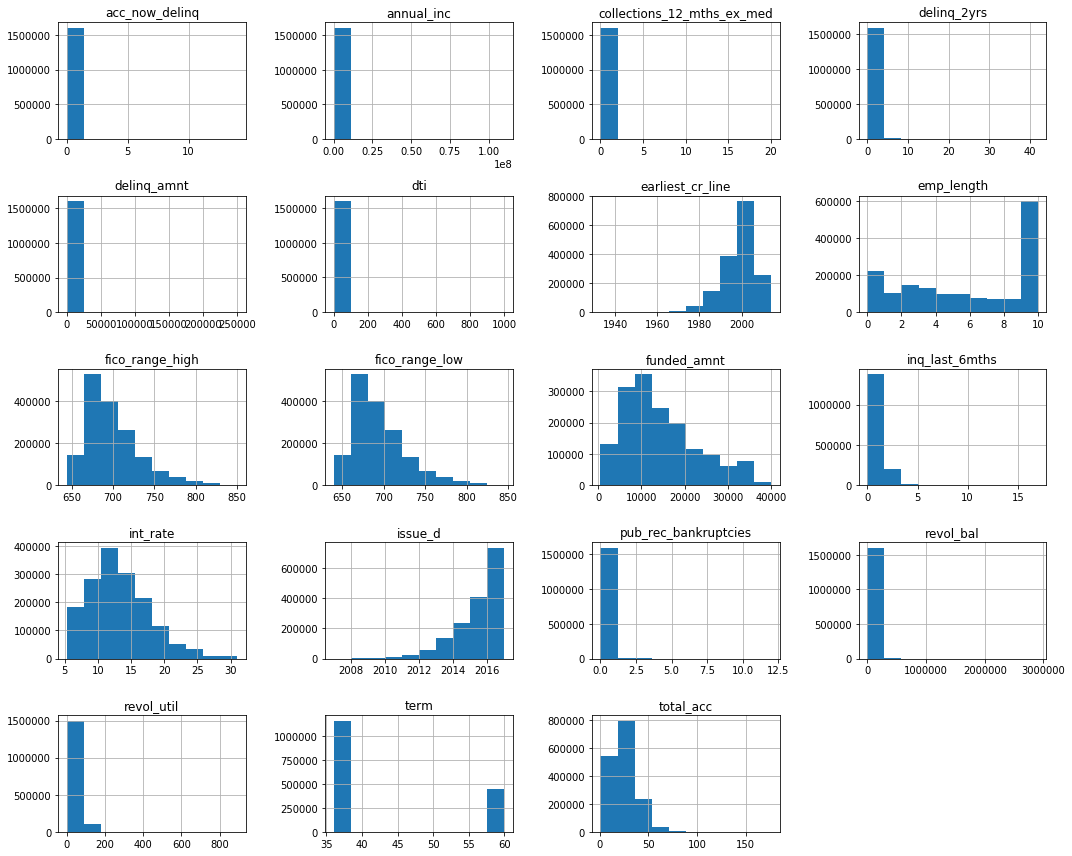

In [31]:
df.hist(figsize=(15,12))
plt.tight_layout()
plt.show()

### Feature Selection
First will start off by dropping features that have majority of their values as 0 and the rest as very rare occurences.  These features won't help much for the model and cannot be log transformed.

In [32]:
drop_list2 = ['delinq_2yrs', 'inq_last_6mths', 'collections_12_mths_ex_med',
             'acc_now_delinq', 'delinq_amnt', 'pub_rec_bankruptcies']

In [33]:
df = df.drop(labels=drop_list2, axis=1)

### FICO Score
Since there is a high and low range for FICO score, I will take the average to create one feature out of the two.

In [34]:
df['fico_score'] = 0.5*df.fico_range_high + 0.5*df.fico_range_low
df = df.drop(['fico_range_high', 'fico_range_low'], axis=1)

### DTI (debt to income ratio)
This feature seems to have some bad outliers, you shouldn't be able to have a debt to income ratio that is greater than 100 

In [35]:
len(df[df['dti']>100])

618

In [37]:
# Since this is a very small amount of the dataset, we can drop these rows.
df = df.drop(df[df['dti']>100].index)

### Log Transform
The following features we will perform log transformation since their histograms show some extreme skewness

In [38]:
df['annual_inc_log'] = np.log(df.annual_inc)
df['total_acc_log'] = np.log(df.total_acc)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603389 entries, 0 to 1606684
Data columns (total 21 columns):
funded_amnt            1603389 non-null float64
term                   1603389 non-null int64
int_rate               1603389 non-null float64
sub_grade              1603389 non-null object
emp_length             1603389 non-null float64
home_ownership         1603389 non-null object
annual_inc             1603389 non-null float64
verification_status    1603389 non-null object
issue_d                1603389 non-null int64
loan_status            1603389 non-null object
purpose                1603389 non-null object
addr_state             1603389 non-null object
dti                    1603389 non-null float64
earliest_cr_line       1603389 non-null float64
revol_bal              1603389 non-null float64
revol_util             1603389 non-null float64
total_acc              1603389 non-null float64
application_type       1603389 non-null object
fico_score             1603389 non

## Create prediction dataframe
Now we will make a seperate dataframe with only current loans in order to be used in the future to make predictions with our final model.  We will explore, train, and test with the remaining data.

In [40]:
current_loans = df[df['loan_status']=='Current']

In [44]:
# Now drop current from df
past_loans = df.drop(current_loans.index)
past_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815768 entries, 0 to 1606679
Data columns (total 21 columns):
funded_amnt            815768 non-null float64
term                   815768 non-null int64
int_rate               815768 non-null float64
sub_grade              815768 non-null object
emp_length             815768 non-null float64
home_ownership         815768 non-null object
annual_inc             815768 non-null float64
verification_status    815768 non-null object
issue_d                815768 non-null int64
loan_status            815768 non-null object
purpose                815768 non-null object
addr_state             815768 non-null object
dti                    815768 non-null float64
earliest_cr_line       815768 non-null float64
revol_bal              815768 non-null float64
revol_util             815768 non-null float64
total_acc              815768 non-null float64
application_type       815768 non-null object
fico_score             815768 non-null float64
annual

### Checkpoint 2

In [45]:
# Create dataframes for loans and current loans
# current_loans.to_csv('current_loans_cleaned.csv', index=False)
# past_loans.to_csv('past_loans_cleaned.csv', index=False)

In [2]:
past_loans = pd.read_csv('Data/past_loans_cleaned.csv')

# EDA

First to start off, let's take a look at the distribution of loans funded. Majority of the loans issued are between \\$10,000 and \\$20,000 with the mean being about $14,000.

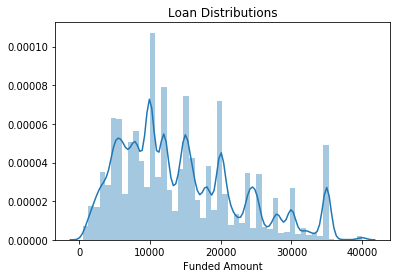

In [3]:
sns.distplot(past_loans.funded_amnt)
plt.title('Loan Distributions')
plt.xlabel('Funded Amount')
plt.show()

## Loans issued by year

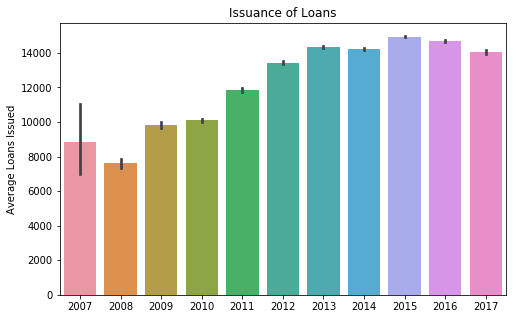

In [4]:
plt.figure(figsize=(8,5))
sns.barplot('issue_d', 'funded_amnt', data=past_loans)
plt.title('Issuance of Loans')
plt.xlabel('')
plt.ylabel('Average Loans Issued')
plt.show()

Can see the increase each year since 2008, probably showing the economy recovering after the financial crisis.  2015 had the highest amount of loans issued.

## Distribution of loan status by year

In [5]:
past_loans.loan_status.value_counts(normalize=True)

Fully Paid     0.79359
Charged Off    0.20641
Name: loan_status, dtype: float64

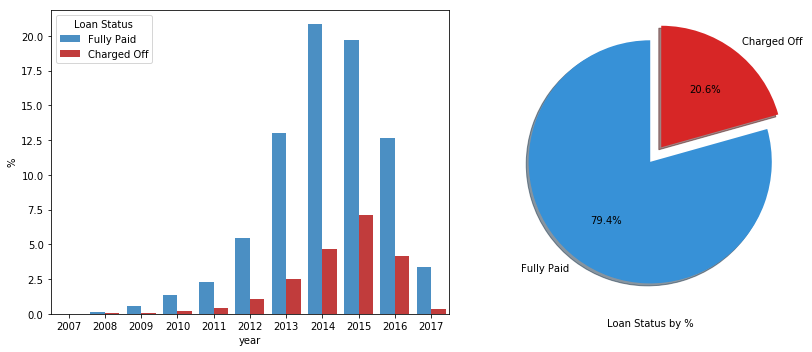

In [6]:
colors = ['#3791D7', '#D72626']
explode = (0, 0.15)
labels = ['Fully Paid', 'Charged Off']
palette = ['#3791D7', '#D72626']

fig, ax = plt.subplots(1,2, figsize=(12,5))

# bar chart
sns.barplot(x='issue_d', y='funded_amnt', hue='loan_status', data=past_loans, palette=palette, 
            estimator=lambda x: len(x) / len(past_loans) * 100, ax=ax[0])
ax[0].set_ylabel('%')
ax[0].set_xlabel('year')
ax[0].legend(title='Loan Status')

# pie chart
plt.pie(past_loans.loan_status.value_counts(), explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].set_xlabel('Loan Status by %')

plt.tight_layout()
plt.show()

Here we can see the break down of loans that are `Fully Paid` versus `Charged Off` from year to year and in the entire dataset.

## Loans by region
Let's break down the states into regions using the image below in order to see how loan status is effected by each region.

<img src='Five-US-Regions1-685x445.jpg'>

In [51]:
past_loans.addr_state.unique()

array(['VA', 'CA', 'MO', 'AZ', 'NJ', 'MN', 'WA', 'MD', 'MI', 'FL', 'NY',
       'KY', 'IN', 'CO', 'IL', 'NC', 'AL', 'CT', 'KS', 'TX', 'PA', 'UT',
       'GA', 'HI', 'NM', 'NH', 'TN', 'MA', 'OH', 'SD', 'OK', 'SC', 'OR',
       'LA', 'VT', 'DC', 'RI', 'NV', 'WV', 'WI', 'AR', 'MT', 'MS', 'WY',
       'AK', 'DE', 'IA', 'ME', 'ID', 'NE', 'ND'], dtype=object)

In [7]:
# Put states into regions
pacific = ['CA', 'OR','WA', 'NV', 'AK', 'HI', 'AZ']
frontier = ['MT', 'ID', 'CO', 'UT', 'WY', 'NM', 'TX', 'KS', 'OK']
mid_west = ['ND', 'SD', 'NE', 'WI', 'MN', 'MI', 'IA', 'IL', 'OH', 'MO', 'IN']
north_east = ['MD', 'DC', 'DE', 'NJ', 'CT', 'PA', 'NY', 'RI','MA', 'NH', 'VT', 'ME']
south = ['AR', 'LA', 'MS', 'AL', 'FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'KY', 'TN']

In [8]:
# Create region column in past_loans
past_loans['region'] = np.nan

def region(state):
    if state in pacific:
        return 'Pacific'
    elif state in frontier:
        return 'Frontier'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    elif state in south:
        return 'South'

past_loans['region'] = past_loans['addr_state'].apply(region)

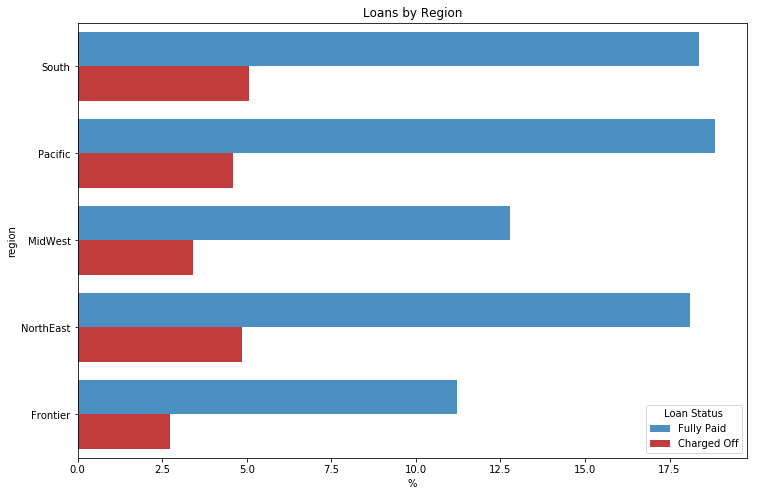

In [9]:
plt.figure(figsize=(12,8))
sns.barplot(x='funded_amnt', y='region', hue='loan_status', data=past_loans, palette=palette,
           estimator=lambda x: len(x) / len(past_loans) * 100)
plt.legend(title='Loan Status')
plt.title('Loans by Region')
plt.xlabel('%')
plt.show()

In [10]:
loans_by_region = past_loans.groupby(['region', 'loan_status']).size()
loans_by_region.unstack()

loan_status,Charged Off,Fully Paid
region,,
Frontier,22197,91568
MidWest,27761,104410
NorthEast,39678,147801
Pacific,37415,153800
South,41332,149806


In [11]:
# show by percentages
region_pct_df = loans_by_region.unstack().divide(loans_by_region.unstack().sum(axis=1), axis=0)
region_pct_df

loan_status,Charged Off,Fully Paid
region,,
Frontier,0.195113,0.804887
MidWest,0.210039,0.789961
NorthEast,0.211640,0.788360
Pacific,0.195670,0.804330
South,0.216242,0.783758


We can see that the majority of the loans are from the Pacific, South, and NorthEast. Note how the despite having the most loans, the Pacific region has a pretty low charge off rate compared to the other regions.

## Loans by interest rate
Now let's explore how loan status changes from year to year with regards to interest rate.

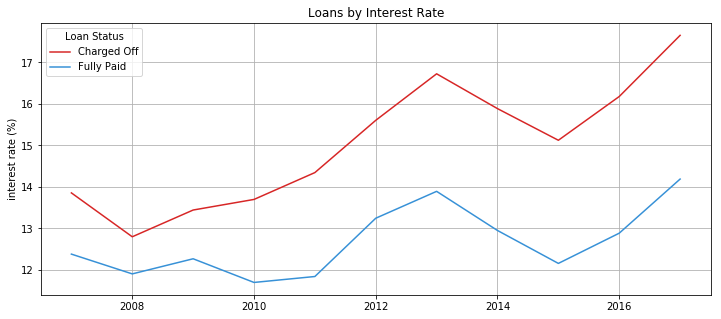

In [12]:
loans_by_interest = past_loans.groupby(['issue_d', 'loan_status']).int_rate.mean()

colors = ['#D72626','#3791D7']
loans_by_interest.unstack().plot(colors=colors, grid=True, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.ylabel('interest rate (%)')
plt.title('Loans by Interest Rate')
plt.show()

Interest rates seem to always be higher for loans that are charged off.  This makes sense since then there is more of a burden for the client to pay back their loan with a higher interest rate.  Interest rates for both fully paid and charged off seem to follow the same pattern except for breifly around 2010 when interest rates diverge a bit.

## Loans by FICO score

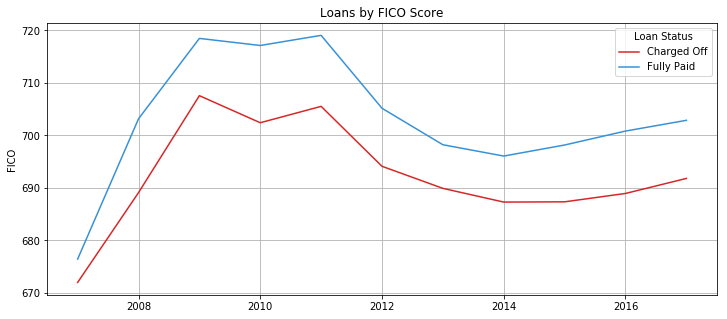

In [13]:
loans_by_fico = past_loans.groupby(['issue_d', 'loan_status']).fico_score.mean()

colors = ['#D72626','#3791D7']
loans_by_fico.unstack().plot(colors=colors, grid=True, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.ylabel('FICO')
plt.title('Loans by FICO Score')
plt.show()

As expected FICO scores are higher on average for fully paid loans versus charged off loans. It is interesting how since 2011 there seems to be some leniency with the FICO score.

## Loans by debt-to-income
Let's now take a look at loans with regards to dti.  Dti is the ratio of the amount of monthly debt being paid back by the loaneed with respect to their income.  

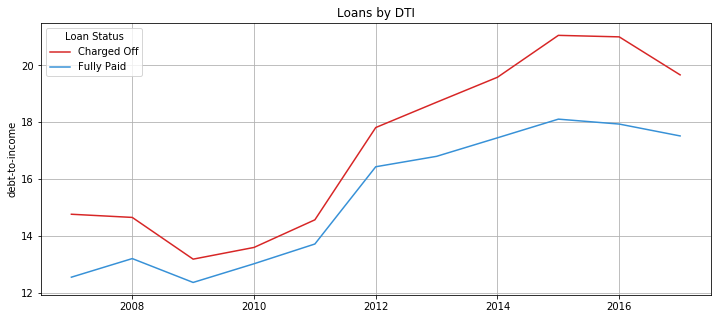

In [14]:
loans_by_dti = past_loans.groupby(['issue_d', 'loan_status']).dti.mean()

colors = ['#D72626','#3791D7']
loans_by_dti.unstack().plot(colors=colors, grid=True, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.ylabel('debt-to-income')
plt.title('Loans by DTI')
plt.show()

As expected dti is lower for fully paid off loans compared to charged off loans.

## Loans by annual income

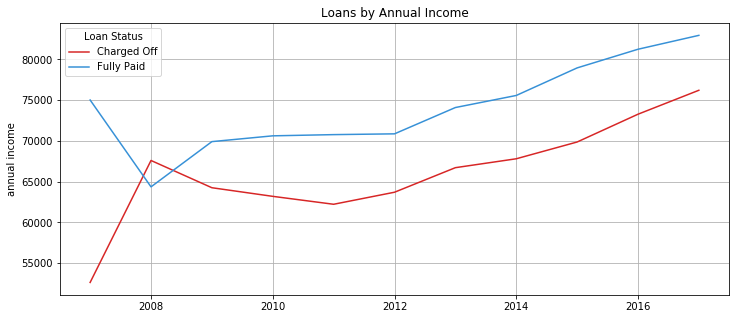

In [15]:
loans_by_income = past_loans.groupby(['issue_d', 'loan_status']).annual_inc.mean()

colors = ['#D72626','#3791D7']
loans_by_income.unstack().plot(colors=colors, grid=True, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.ylabel('annual income')
plt.title('Loans by Annual Income')
plt.show()

Very unexpected to see any point where average annual income is lower for charged off loans than fully paid loans.  The fact that this only happend around 2008 during the financial crisis is probably not a coincidence.

## Loans by subgrade
Now let's take a look at the loans based on their subgrade.  This [link](https://www.lendingclub.com/foliofn/rateDetail.action) explains the different grades and subgrades by interest rate. Might have to remove interest rate feature later due to collinearity issues.  

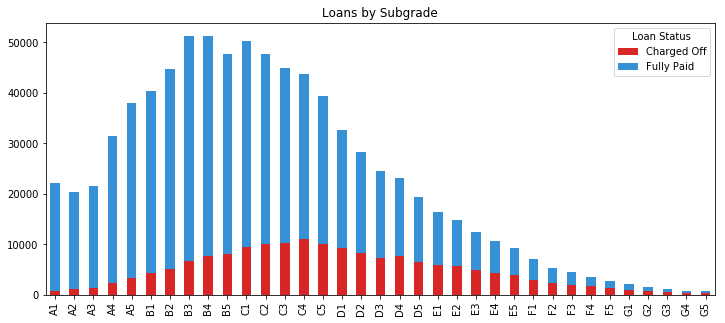

In [16]:
loans_by_subgrade = past_loans.groupby(['sub_grade', 'loan_status']).size()
colors = ['#D72626','#3791D7']

loans_by_subgrade.unstack().plot(kind='bar', stacked=True, colors=colors, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.title('Loans by Subgrade')
plt.show()

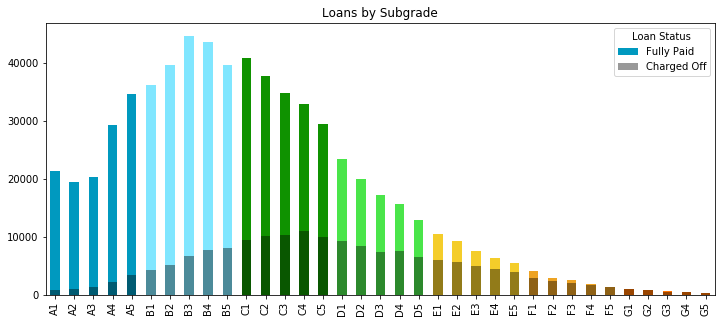

In [17]:
loans_by_subgrade = past_loans.groupby(['sub_grade', 'loan_status']).size()

colors = ['#0099bf','#0099bf','#0099bf','#0099bf','#0099bf', 
          '#80e6ff','#80e6ff','#80e6ff','#80e6ff','#80e6ff',
          '#0f9200','#0f9200','#0f9200','#0f9200','#0f9200',
          '#4ae54a','#4ae54a','#4ae54a','#4ae54a','#4ae54a',
          '#f4cd2a','#f4cd2a','#f4cd2a','#f4cd2a','#f4cd2a',
          '#eda323','#eda323','#eda323','#eda323','#eda323',
          '#ff7400','#ff7400','#ff7400','#ff7400','#ff7400',]

loans_by_subgrade.unstack()['Fully Paid'].plot(kind='bar', color=colors, figsize=(12,5))
loans_by_subgrade.unstack()['Charged Off'].plot(kind='bar', colors='k', figsize=(12,5),alpha=0.4)

plt.legend(title='Loan Status')
plt.xlabel('')
plt.title('Loans by Subgrade')
plt.show()

Interesting how the loans with the most charge offs are in the C-D range, probably since LendingClub is less likely to give that many low grade (E,F,G) loans out since they are more risky.

In [18]:
loans_by_subgrade.unstack()

loan_status,Charged Off,Fully Paid
sub_grade,,
A1,754,21293
A2,1043,19334
A3,1247,20202
A4,2261,29225
A5,3396,34604
B1,4236,36185
B2,5137,39502
B3,6696,44606
B4,7624,43577


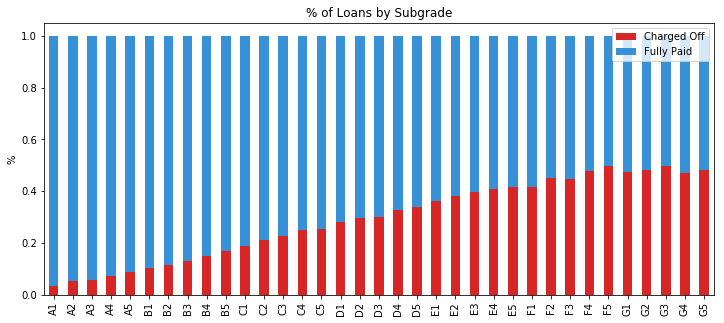

In [19]:
# show by percentages
subgrade_pct_df = loans_by_subgrade.unstack().divide(loans_by_subgrade.unstack().sum(axis=1), 
                                                     axis=0)
colors = ['#D72626','#3791D7']

subgrade_pct_df.plot(kind='bar', stacked=True, figsize=(12,5), colors=colors)
plt.title('% of Loans by Subgrade')
plt.xlabel('')
plt.ylabel('%')
plt.legend(loc='upper right')
plt.show()

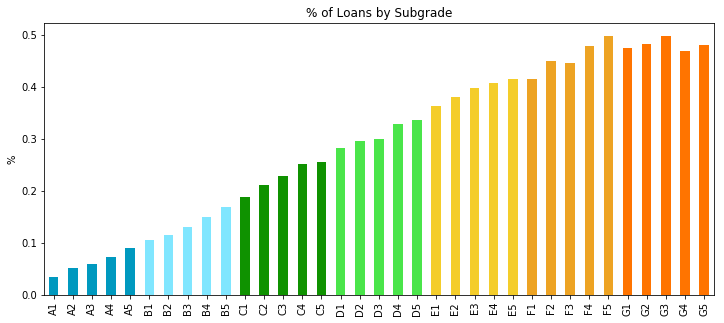

In [20]:
subgrade_pct_df = loans_by_subgrade.unstack().divide(loans_by_subgrade.unstack().sum(axis=1), 
                                                     axis=0)
colors = ['#0099bf','#0099bf','#0099bf','#0099bf','#0099bf', 
          '#80e6ff','#80e6ff','#80e6ff','#80e6ff','#80e6ff',
          '#0f9200','#0f9200','#0f9200','#0f9200','#0f9200',
          '#4ae54a','#4ae54a','#4ae54a','#4ae54a','#4ae54a',
          '#f4cd2a','#f4cd2a','#f4cd2a','#f4cd2a','#f4cd2a',
          '#eda323','#eda323','#eda323','#eda323','#eda323',
          '#ff7400','#ff7400','#ff7400','#ff7400','#ff7400',]

subgrade_pct_df.unstack()['Charged Off'].plot(kind='bar', figsize=(12,5), colors=colors)
plt.title('% of Loans by Subgrade')
plt.xlabel('')
plt.ylabel('%')
plt.show()

This chart shows how percentage of being charged off relative to the loan's subgrade.  Naturally lower grade loans are going to be more likely to be charged off.

## Loans by home ownership
Now let's take a look at loans based on home ownership

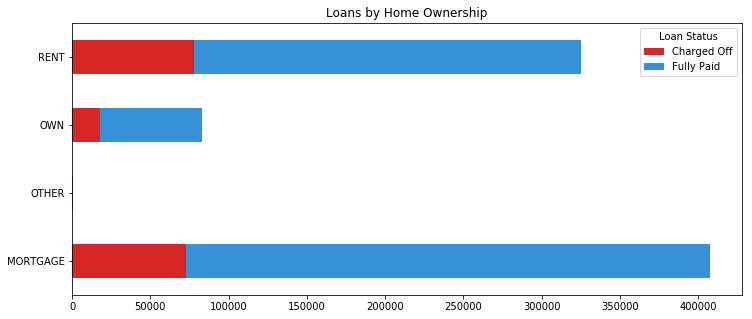

In [21]:
loans_by_homes = past_loans.groupby(['home_ownership', 'loan_status']).size()
colors = ['#D72626','#3791D7']

loans_by_homes.unstack().plot(kind='barh', stacked=True, colors=colors, figsize=(12,5))
plt.title('Loans by Home Ownership')
plt.ylabel('')
plt.legend(title='Loan Status')
plt.show()

In [22]:
loans_by_homes.unstack()

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,72503,334829
OTHER,61,256
OWN,17861,64903
RENT,77958,247397


In [23]:
homes_pct_df = loans_by_homes.unstack().divide(loans_by_homes.unstack().sum(axis=1), axis=0)
homes_pct_df

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,0.177995,0.822005
OTHER,0.192429,0.807571
OWN,0.215806,0.784194
RENT,0.239609,0.760391


It looks like a loan is more likely to be charged off if the client is renting versus owning a home or paying a mortgage.  Not quite sure the difference between OWN and MORTGAGE though.

## Loans by purpose

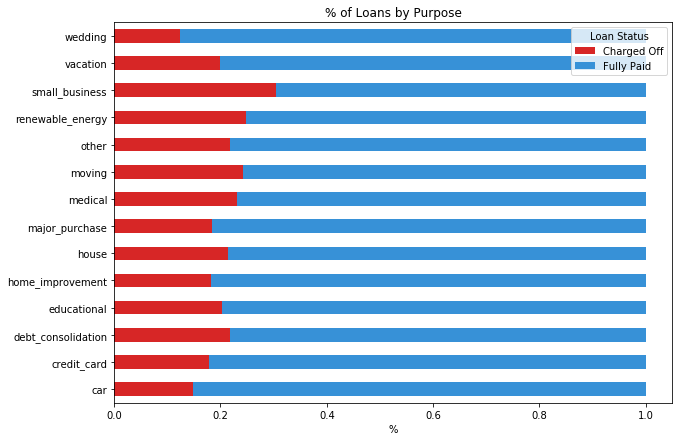

In [24]:
loans_by_purpose = past_loans.groupby(['purpose', 'loan_status']).size()
purpose_pct_df = loans_by_purpose.unstack().divide(loans_by_purpose.unstack().sum(axis=1), axis=0)
purpose_pct_df.plot(kind='barh', stacked=True, colors=colors, figsize=(10,7))
plt.title('% of Loans by Purpose')
plt.ylabel('')
plt.xlabel('%')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

In [25]:
purpose_pct_df

loan_status,Charged Off,Fully Paid
purpose,,
car,0.147979,0.852021
credit_card,0.178498,0.821502
debt_consolidation,0.217478,0.782522
educational,0.202186,0.797814
home_improvement,0.181786,0.818214
house,0.214996,0.785004
major_purchase,0.183251,0.816749
medical,0.230366,0.769634
moving,0.242895,0.757105


Top percentage of being charged off is under small business, moving, and renewable energy. Least likely are for weddings, cars, and credit card loans.

## Loans by term

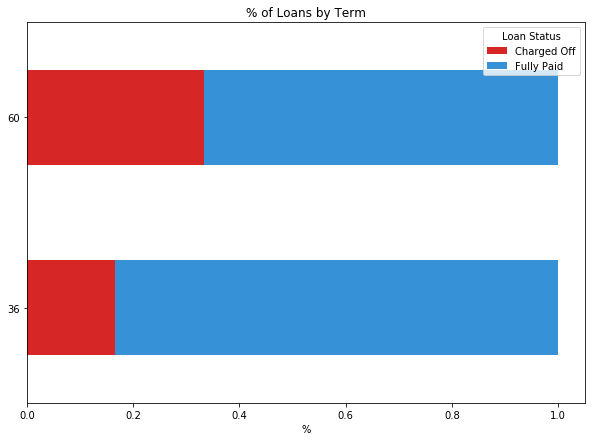

In [26]:
loans_by_term = past_loans.groupby(['term', 'loan_status']).size()
term_pct_df = loans_by_term.unstack().divide(loans_by_term.unstack().sum(axis=1), axis=0)
term_pct_df.plot(kind='barh', stacked=True, colors=colors, figsize=(10,7))
plt.title('% of Loans by Term')
plt.ylabel('')
plt.xlabel('%')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

In [27]:
term_pct_df

loan_status,Charged Off,Fully Paid
term,,
36,0.165905,0.834095
60,0.333882,0.666118


Looks like loans with a 60 month term are about twice as likely to be charged off than loans with a 36 month term

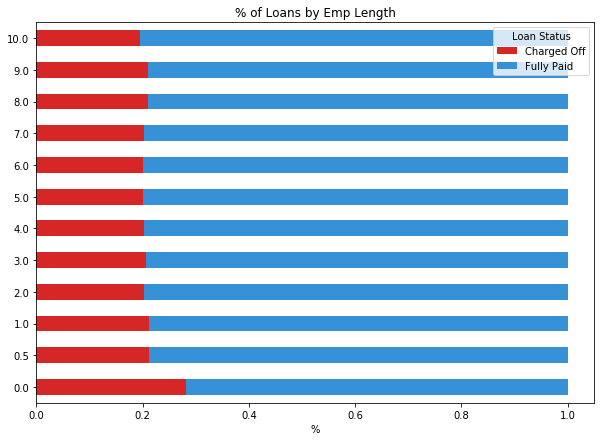

In [28]:
loans_by_emp_length = past_loans.groupby(['emp_length', 'loan_status']).size()
emp_length_pct_df = loans_by_emp_length.unstack().divide(loans_by_emp_length.unstack().sum(axis=1), axis=0)
emp_length_pct_df.plot(kind='barh', stacked=True, colors=colors, figsize=(10,7))
plt.title('% of Loans by Emp Length')
plt.ylabel('')
plt.xlabel('%')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

# Modeling

In [29]:
past_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815768 entries, 0 to 815767
Data columns (total 22 columns):
funded_amnt            815768 non-null float64
term                   815768 non-null int64
int_rate               815768 non-null float64
sub_grade              815768 non-null object
emp_length             815768 non-null float64
home_ownership         815768 non-null object
annual_inc             815768 non-null float64
verification_status    815768 non-null object
issue_d                815768 non-null int64
loan_status            815768 non-null object
purpose                815768 non-null object
addr_state             815768 non-null object
dti                    815768 non-null float64
earliest_cr_line       815768 non-null float64
revol_bal              815768 non-null float64
revol_util             815768 non-null float64
total_acc              815768 non-null float64
application_type       815768 non-null object
fico_score             815768 non-null float64
annual_

In [30]:
# Drop columns that had been log transformed and also columns that are reduntant or not needed for modeling
past_loans = past_loans.drop(['annual_inc', 'total_acc', 'int_rate', 'region', 
                            'application_type', 'issue_d'], axis=1)

## Set target variable
Here we will set our target variable by changing the labels under `loan_status` to a 1 for being fully paid or a 0 for being charged off.

In [31]:
past_loans.loan_status.value_counts(normalize=True)

Fully Paid     0.79359
Charged Off    0.20641
Name: loan_status, dtype: float64

In [33]:
# Turn target variable into 1's and 0's
# 1 = Fully Paid, 0 = Charged Off
past_loans['fully_paid'] = past_loans.loan_status.astype('category').cat.codes
past_loans = past_loans.drop('loan_status', axis=1)

In [35]:
past_loans.fully_paid.value_counts(normalize=True)

1    0.79359
0    0.20641
Name: fully_paid, dtype: float64

## Set X and y variables and get dummies

In [36]:
X = past_loans.drop('fully_paid', axis=1)
y = past_loans.fully_paid
X = pd.get_dummies(X, drop_first=True)

In [37]:
X.shape

(815768, 112)

## Split data and upsample and scale

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [39]:
# Check the split of the target variable
y_train.value_counts(normalize=True)

1    0.793819
0    0.206181
Name: fully_paid, dtype: float64

In [40]:
# Use SMOTE to deal with unbalanced dataset by upsampling
# Should be done after splitting data to avoid data leakage
X_train, y_train = SMOTE(random_state=0).fit_sample(X_train, y_train) 

# checking the shape of x_resample and y_resample
print("Shape of X:", X_train.shape)
print("Shape of y:", y_train.shape)

Shape of X: (971358, 112)
Shape of y: (971358,)


In [41]:
# Check SMOTE upsampling
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int8), array([485679, 485679]))

In [42]:
# Scale the data, only fit training data to avoid data leakage
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## XGBoost
Although this is a deep learning project, it is good practice to test simpler machine learning models to compare and see if the more computationally expenseive neural network is worth building.

In [43]:
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [102]:
training_preds = clf_xgb.predict(X_train)
test_preds = clf_xgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test Accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 86.39%
Test Accuracy: 79.15%


In [103]:
X_train = pd.DataFrame(X_train, columns=X.columns)

In [104]:
ft_weights = pd.DataFrame(clf_xgb.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights.sort_values('weight', inplace=True)

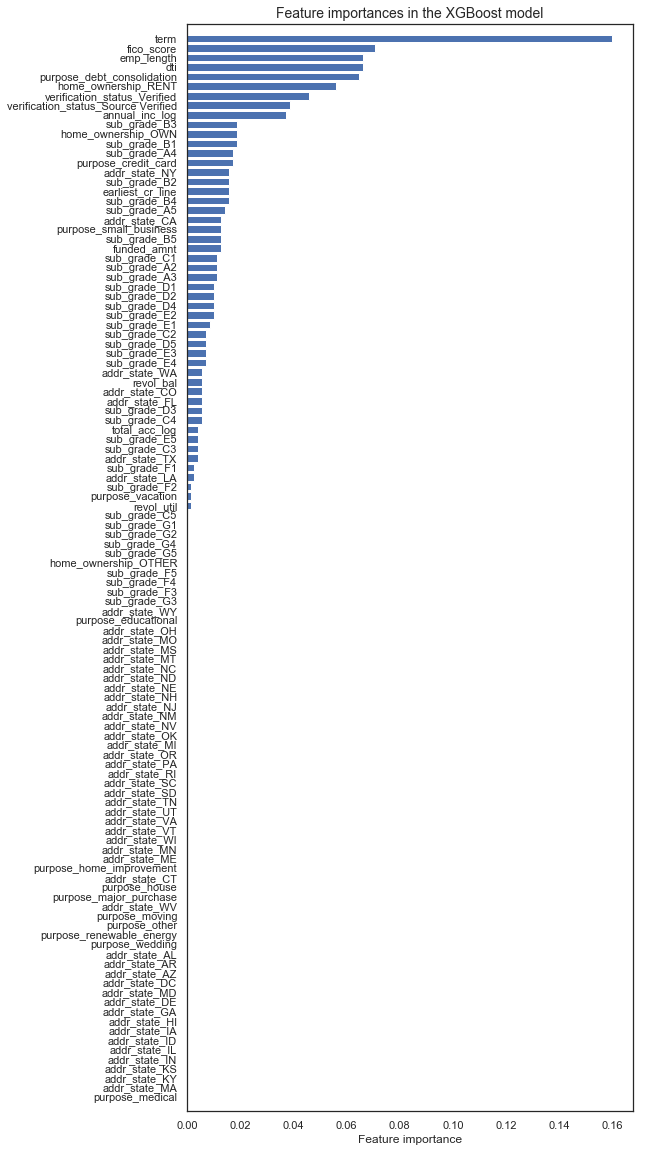

In [105]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights.index, ft_weights.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## Baseline Model
To start we will build a simple MLP model to compare

In [106]:
# Baseline model
input_shape = X_train.shape
model = Sequential()
model.add(Dense(12, kernel_initializer='uniform', activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                1356      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,469
Trainable params: 1,469
Non-trainable params: 0
_________________________________________________________________


In [107]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
model_val = model.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/5
971274/971274 [==============================] - 37s 38us/step - loss: 0.5029 - acc: 0.7491 - val_loss: 0.5313 - val_acc: 0.7393
Epoch 2/5
971274/971274 [==============================] - 37s 38us/step - loss: 0.4268 - acc: 0.7971 - val_loss: 0.5414 - val_acc: 0.7318
Epoch 3/5
971274/971274 [==============================] - 37s 38us/step - loss: 0.4144 - acc: 0.8032 - val_loss: 0.5136 - val_acc: 0.7557
Epoch 4/5
971274/971274 [==============================] - 40s 41us/step - loss: 0.4079 - acc: 0.8060 - val_loss: 0.5042 - val_acc: 0.7642
Epoch 5/5
971274/971274 [==============================] - 38s 39us/step - loss: 0.4035 - acc: 0.8087 - val_loss: 0.5223 - val_acc: 0.7455


In [109]:
train_score = model.evaluate(X_train, y_train)
test_score = model.evaluate(X_test, y_test)
print('Train Score:', train_score)
print('Test Score:', test_score)

203942/203942 [==============================] - 10s 49us/step
Train Score: [0.39970854002105, 0.8076196830140224]
Test Score: [0.522297196881888, 0.7454962685463553]


In [110]:
model_dict = model_val.history

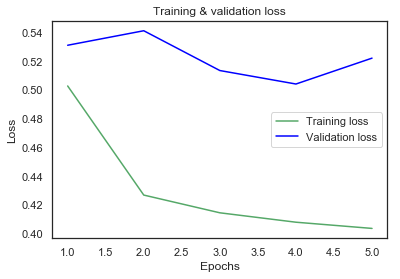

In [111]:
plt.clf()

loss_values = model_dict['loss']
val_loss_values = model_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

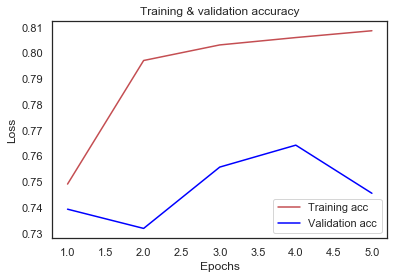

In [112]:
plt.clf()

acc_values = model_dict['acc'] 
val_acc_values = model_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some slight over fitting and it get slightly lower accuracy to the XGBoost model.  Now let's start iterating through our MLP to see if we can improve accuracy and limit overfitting.

## Model 2 (More layers and bigger layers)

In [113]:
# More layers and bigger layers
input_shape = X_train.shape
model2 = Sequential()
model2.add(Dense(34, kernel_initializer='uniform', activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(68, kernel_initializer='uniform', activation='relu'))
model2.add(Dense(68, kernel_initializer='uniform', activation='relu'))
model2.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 34)                3842      
_________________________________________________________________
dense_5 (Dense)              (None, 68)                2380      
_________________________________________________________________
dense_6 (Dense)              (None, 68)                4692      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 69        
Total params: 10,983
Trainable params: 10,983
Non-trainable params: 0
_________________________________________________________________


In [114]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [115]:
model_val2 = model2.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/5
971274/971274 [==============================] - 48s 49us/step - loss: 0.4046 - acc: 0.8034 - val_loss: 0.4891 - val_acc: 0.7761
Epoch 2/5
971274/971274 [==============================] - 48s 49us/step - loss: 0.3626 - acc: 0.8275 - val_loss: 0.4819 - val_acc: 0.7814
Epoch 3/5
971274/971274 [==============================] - 54s 55us/step - loss: 0.3547 - acc: 0.8322 - val_loss: 0.4811 - val_acc: 0.7849
Epoch 4/5
971274/971274 [==============================] - 45s 47us/step - loss: 0.3494 - acc: 0.8353 - val_loss: 0.4987 - val_acc: 0.7707
Epoch 5/5
971274/971274 [==============================] - 49s 50us/step - loss: 0.3453 - acc: 0.8379 - val_loss: 0.4789 - val_acc: 0.7837


In [116]:
train_score2 = model2.evaluate(X_train, y_train)
test_score2 = model2.evaluate(X_test, y_test)
print('Train Score:', train_score2)
print('Test Score:', test_score2)

203942/203942 [==============================] - 12s 58us/step
Train Score: [0.3373100290647233, 0.8430607634920733]
Test Score: [0.47888680215136564, 0.7836983063806415]


In [117]:
model_dict2 = model_val2.history

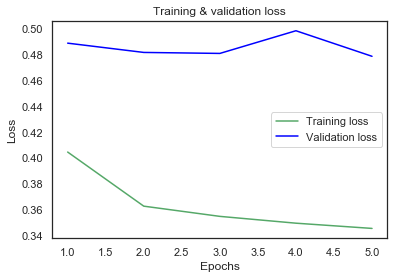

In [118]:
plt.clf()

loss_values = model_dict2['loss']
val_loss_values = model_dict2['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

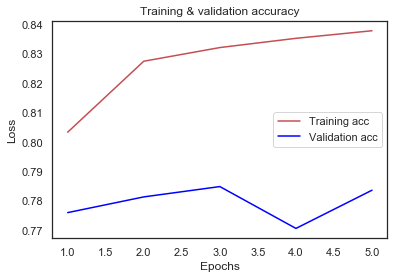

In [119]:
plt.clf()

acc_values = model_dict2['acc'] 
val_acc_values = model_dict2['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 3 (L1 regularization)
With the deeper model there was more over fitting so let's test L1 and L2 regularization to fix this.

In [120]:
# Add L1 Regularizer and more epochs
input_shape = X_train.shape
model3 = Sequential()
model3.add(Dense(34, kernel_initializer='normal', activation='relu', input_shape=(X_train.shape[1],)))
model3.add(Dense(68, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model3.add(Dense(68, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model3.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 34)                3842      
_________________________________________________________________
dense_9 (Dense)              (None, 68)                2380      
_________________________________________________________________
dense_10 (Dense)             (None, 68)                4692      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 69        
Total params: 10,983
Trainable params: 10,983
Non-trainable params: 0
_________________________________________________________________


In [121]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [122]:
model_val3 = model3.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/5
971274/971274 [==============================] - 49s 51us/step - loss: 0.5108 - acc: 0.7877 - val_loss: 0.5326 - val_acc: 0.7818
Epoch 2/5
971274/971274 [==============================] - 50s 51us/step - loss: 0.4032 - acc: 0.8316 - val_loss: 0.5164 - val_acc: 0.7863
Epoch 3/5
971274/971274 [==============================] - 50s 51us/step - loss: 0.3896 - acc: 0.8359 - val_loss: 0.5621 - val_acc: 0.7413
Epoch 4/5
971274/971274 [==============================] - 50s 52us/step - loss: 0.3816 - acc: 0.8381 - val_loss: 0.5254 - val_acc: 0.7729
Epoch 5/5
971274/971274 [==============================] - 50s 52us/step - loss: 0.3761 - acc: 0.8393 - val_loss: 0.5147 - val_acc: 0.7803


In [123]:
train_score3 = model3.evaluate(X_train, y_train)
test_score3 = model3.evaluate(X_test, y_test)
print('Train Score:', train_score3)
print('Test Score:', test_score3)

203942/203942 [==============================] - 12s 60us/step
Train Score: [0.36722489674681363, 0.8435127471753594]
Test Score: [0.5147459500216798, 0.7803100881629051]


In [124]:
model_dict3 = model_val3.history

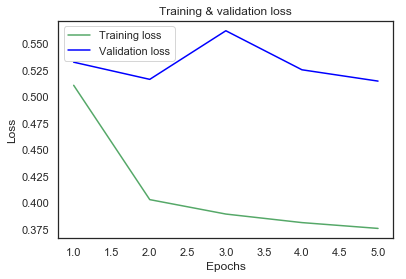

In [125]:
plt.clf()

loss_values = model_dict3['loss']
val_loss_values = model_dict3['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

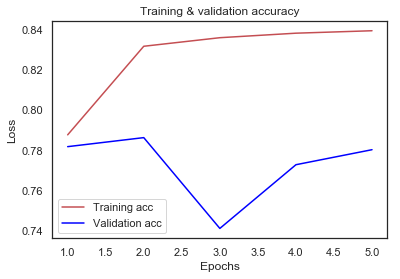

In [126]:
plt.clf()

acc_values = model_dict3['acc'] 
val_acc_values = model_dict3['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 4 (L2 regularization)

In [127]:
# Add L2 Regularizer and more epochs
input_shape = X_train.shape
model4 = Sequential()
model4.add(Dense(34, kernel_initializer='normal', activation='relu', input_shape=(X_train.shape[1],)))
model4.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model4.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model4.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 34)                3842      
_________________________________________________________________
dense_13 (Dense)             (None, 68)                2380      
_________________________________________________________________
dense_14 (Dense)             (None, 68)                4692      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 69        
Total params: 10,983
Trainable params: 10,983
Non-trainable params: 0
_________________________________________________________________


In [128]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [129]:
model_val4 = model4.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/5
971274/971274 [==============================] - 53s 55us/step - loss: 0.4323 - acc: 0.7998 - val_loss: 0.4936 - val_acc: 0.7849
Epoch 2/5
971274/971274 [==============================] - 51s 52us/step - loss: 0.3699 - acc: 0.8302 - val_loss: 0.4900 - val_acc: 0.7838
Epoch 3/5
971274/971274 [==============================] - 51s 52us/step - loss: 0.3581 - acc: 0.8358 - val_loss: 0.4854 - val_acc: 0.7842
Epoch 4/5
971274/971274 [==============================] - 50s 52us/step - loss: 0.3509 - acc: 0.8389 - val_loss: 0.4781 - val_acc: 0.7911
Epoch 5/5
971274/971274 [==============================] - 50s 52us/step - loss: 0.3475 - acc: 0.8407 - val_loss: 0.4813 - val_acc: 0.7884


In [130]:
train_score4 = model4.evaluate(X_train, y_train)
test_score4 = model4.evaluate(X_test, y_test)
print('Train Score:', train_score4)
print('Test Score:', test_score4)

203942/203942 [==============================] - 12s 59us/step
Train Score: [0.3440828390805477, 0.8430288466488344]
Test Score: [0.48130810786728706, 0.788430043835408]


In [131]:
model_dict4 = model_val4.history

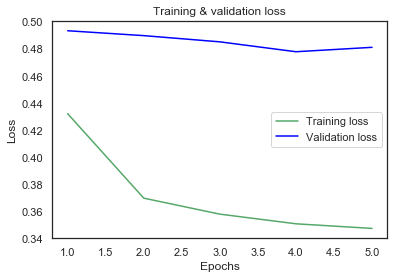

In [132]:
plt.clf()

loss_values = model_dict4['loss']
val_loss_values = model_dict4['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

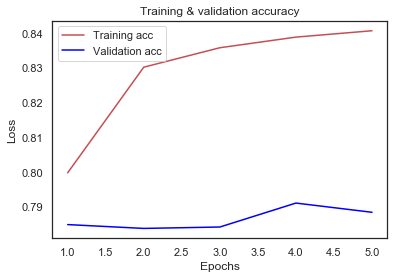

In [133]:
plt.clf()

acc_values = model_dict4['acc'] 
val_acc_values = model_dict4['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 5 (L2 regularization, dropout layers, more epochs)
Well it looks like the model with L2 regularizers worked a little better, let's try using dropout layers to try and help more with overfitting.

In [134]:
# Add L2 Regularizer and more epochs and dropout layers
input_shape = X_train.shape
model5 = Sequential()
model5.add(Dense(34, kernel_initializer='normal', activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 34)                3842      
_________________________________________________________________
dense_17 (Dense)             (None, 68)                2380      
_________________________________________________________________
dropout_1 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 68)                4692      
_________________________________________________________________
dropout_2 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 69        
Total params: 10,983
Trainable params: 10,983
Non-trainable params: 0
_________________________________________________________________


In [135]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [136]:
model_val5 = model5.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/5
971274/971274 [==============================] - 58s 59us/step - loss: 0.4483 - acc: 0.7926 - val_loss: 0.5147 - val_acc: 0.7686
Epoch 2/5
971274/971274 [==============================] - 58s 60us/step - loss: 0.3847 - acc: 0.8238 - val_loss: 0.4932 - val_acc: 0.7847
Epoch 3/5
971274/971274 [==============================] - 58s 60us/step - loss: 0.3742 - acc: 0.8288 - val_loss: 0.4851 - val_acc: 0.7873
Epoch 4/5
971274/971274 [==============================] - 61s 62us/step - loss: 0.3685 - acc: 0.8315 - val_loss: 0.4859 - val_acc: 0.7903
Epoch 5/5
971274/971274 [==============================] - 60s 61us/step - loss: 0.3650 - acc: 0.8330 - val_loss: 0.4813 - val_acc: 0.7882


In [137]:
train_score5 = model5.evaluate(X_train, y_train)
test_score5 = model5.evaluate(X_test, y_test)
print('Train Score:', train_score5)
print('Test Score:', test_score5)

203942/203942 [==============================] - 13s 66us/step
Train Score: [0.35896869096496326, 0.8340056461925265]
Test Score: [0.48128007614000345, 0.7881799727367623]


In [138]:
model_dict5 = model_val5.history

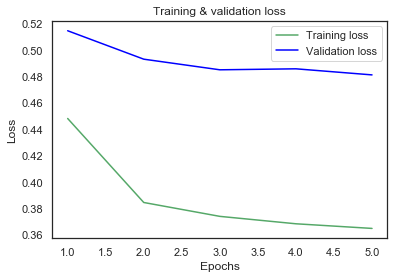

In [139]:
plt.clf()

loss_values = model_dict5['loss']
val_loss_values = model_dict5['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

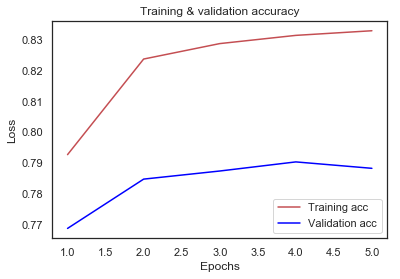

In [140]:
plt.clf()

acc_values = model_dict5['acc'] 
val_acc_values = model_dict5['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Final Model (Much more epochs)
With the above model looking like validation accuracy could possibly keep increasing, we will now train this model for longer to see if that increases accuracy.

In [141]:
# Final model with L2 and dropout layers and more epochs
input_shape = X_train.shape
model6 = Sequential()
model6.add(Dense(34, kernel_initializer='normal', activation='relu', input_shape=(X_train.shape[1],)))
model6.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 34)                3842      
_________________________________________________________________
dense_21 (Dense)             (None, 68)                2380      
_________________________________________________________________
dropout_3 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 68)                4692      
_________________________________________________________________
dropout_4 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 69        
Total params: 10,983
Trainable params: 10,983
Non-trainable params: 0
_________________________________________________________________


In [142]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [152]:
model_val6 = model6.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/100
971274/971274 [==============================] - 33s 33us/step - loss: 0.4096 - acc: 0.8163 - val_loss: 0.5134 - val_acc: 0.7655
Epoch 2/100
971274/971274 [==============================] - 39s 40us/step - loss: 0.3776 - acc: 0.8303 - val_loss: 0.4886 - val_acc: 0.7878
Epoch 3/100
971274/971274 [==============================] - 28s 29us/step - loss: 0.3675 - acc: 0.8344 - val_loss: 0.5027 - val_acc: 0.7779
Epoch 4/100
971274/971274 [==============================] - 28s 29us/step - loss: 0.3619 - acc: 0.8365 - val_loss: 0.4849 - val_acc: 0.7913
Epoch 5/100
971274/971274 [==============================] - 31s 32us/step - loss: 0.3581 - acc: 0.8379 - val_loss: 0.4820 - val_acc: 0.7933
Epoch 6/100
971274/971274 [==============================] - 37s 38us/step - loss: 0.3556 - acc: 0.8391 - val_loss: 0.4845 - val_acc: 0.7890
Epoch 7/100
971274/971274 [==============================] - 28s 29us/step - loss: 0.3538 - acc: 0.839

In [153]:
train_score6 = model6.evaluate(X_train, y_train)
test_score6 = model6.evaluate(X_test, y_test)
print('Train Score:', train_score6)
print('Test Score:', test_score6)

203942/203942 [==============================] - 13s 65us/step
Train Score: [0.3239047424617523, 0.8537251074362127]
Test Score: [0.47512623614115995, 0.7917839385701856]


In [154]:
model_dict6 = model_val6.history

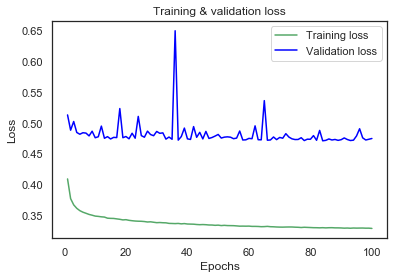

In [155]:
plt.clf()

loss_values = model_dict6['loss']
val_loss_values = model_dict6['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

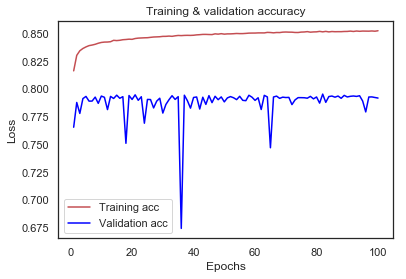

In [156]:
plt.clf()

acc_values = model_dict6['acc'] 
val_acc_values = model_dict6['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Conclusion
Well a bit disappointing, although accuracy ended up being around 79%, it seems that the model would be better off using early stopping and just using 5 or so epochs.  Also note that the MLP could never get significant accuracy scores better than the XGBoost model so maybe in a real use case, deep learning wouldn't be necessary for this type of problem.

# Future Work
- Use current loans df and model to make predictions
- Gather more data
- Further explore features for different feature selections
- Test different initializers and optimizers
- Experiment with more feature engineering
- Look more into imbalanced classes